In [1]:
# import standard numerical modules
import numpy as np
import math
import tensorflow as tf
import gc

import DCTR


2024-04-30 12:22:11.891496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-30 12:22:11.891536: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
from importlib import reload
reload(DCTR)


In [2]:
data_dir = './Data/'


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:9553938] # 9553938 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))


POWHEG hvq all particles X0_plt.shape: (9553938, 3, 9)


In [4]:
# normalized dataset for calculating rwgt
X0_test = []
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:9553938]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))


POWHEG hvq all particles X0_test.shape: (9553938, 3, 9)


In [5]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles X1_plt.shape: '+str(X1_plt.shape))


MiNNLO all particles X1_plt.shape: (9553938, 3, 9)


In [6]:
# get event generator weights
X0_plt_wgt = X0_plt[:, 0, 7].copy()
X1_plt_wgt = X1_plt[:, 0, 7].copy()


In [7]:
print(f'X0_plt_wgt (min, max, mean): {min(X0_plt_wgt), max(X0_plt_wgt), np.mean(X0_plt_wgt)}')
print(f'X1_plt_wgt (min, max, mean): {min(X1_plt_wgt), max(X1_plt_wgt), np.mean(X1_plt_wgt)}')


X0_plt_wgt (min, max, mean): (-692.465, 692.465, 686.4671955083866)
X1_plt_wgt (min, max, mean): (-103.245, 103.245, 83.13098417846136)


In [8]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)

# garbage collection
print(gc.collect())


11


In [9]:
model = './best_model.tf' # path to previously trained model (in .tf format (folder))

''' # save weights to .h5 file
dctr = tf.keras.models.load_model(model)
dctr.save('best_model_weights.h5')
'''

# calculate rwgt
with tf.device('CPU'):
    rwgt = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook

# apply orginal generator weights to rwgt
rwgt = np.multiply(rwgt[0], X0_plt_wgt)

print(f'X0 rwgt (min, max, mean): {min(rwgt), max(rwgt), np.mean(rwgt)}')


2024-04-30 12:30:40.490325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-30 12:30:40.492268: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-30 12:30:40.494192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (finn-ThinkPad-T540p): /proc/driver/nvidia/version does not exist
2024-04-30 12:30:40.534863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 12:30:43.681765: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5732362

X0 rwgt (min, max, mean): (-5002.869879303932, 827275.0301689453, 527.9226660949363)


In [17]:
%whos
print(gc.collect())


Variable             Type        Data/Info
------------------------------------------
DCTR                 module      <module 'DCTR' from '/hom<...>per/git/DCTR_FP/DCTR.py'>
DCTR_corr_comp_top   ndarray     6x6: 36 elems, type `float64`, 288 bytes
DCTR_corr_comp_tt    ndarray     6x6: 36 elems, type `float64`, 288 bytes
X0_full              ndarray     1000000x12: 12000000 elems, type `float64`, 96000000 bytes (91.552734375 Mb)
X0_plt               ndarray     9553938x3x9: 257956326 elems, type `float64`, 2063650608 bytes (1968.0505828857422 Mb)
X0_plt_wgt           ndarray     9553938: 9553938 elems, type `float64`, 76431504 bytes (72.89076232910156 Mb)
X0_test              ndarray     9553938x3x7: 200632698 elems, type `float64`, 1605061584 bytes (1530.7060089111328 Mb)
X1_full              ndarray     1000000x12: 12000000 elems, type `float64`, 96000000 bytes (91.552734375 Mb)
X1_plt               ndarray     9553938x3x9: 257956326 elems, type `float64`, 2063650608 bytes (1968.0505

In [18]:
# covariance matrix using weighted samples
def weighted_cov(data, weights):
    # print(f'{np.shape(data) = }')

    # Calculate weighted mean
    weighted_mean = np.average(data, axis=0, weights=weights)
    # print(f'{np.shape(weighted_mean) = }')
    # print(f'{weighted_mean = }')

    # Calculate centered data
    centered_data = data - weighted_mean[np.newaxis, :]
    # print(f'{np.shape(centered_data) = }')

    # Calculate weighted covariance matrix
    vars = len(data[0,:]) # num of variables per sample
    weighted_covariance = np.zeros(shape=(vars, vars))
    for i in range(vars):
        for j in range(vars):
            weighted_covariance[i, j] = np.sum(
                weights * centered_data[:,i] * centered_data[:,j]) / np.sum(weights)

    return weighted_covariance
    

# correlation matrix using weighted samples
def weighted_corr(data, weights):
    cov = weighted_cov(data, weights)

    # Calculate diagonal matrix for standard deviations
    std_dev = np.sqrt(np.diag(cov))
    std_dev_matrix = np.outer(std_dev, std_dev)

    # Calculate correlation matrix
    weighted_correlation = cov / std_dev_matrix

    return weighted_correlation
    


In [19]:
import matplotlib.pyplot as plt

def plot_matrix(matrix, title, vmin=None, vmax=None):
    variable_labels = [r'$p_T$', r'$y$', r'$\phi$', r'$m$', r'$\eta$', r'$E$']  # Labels for variables
    
    figsize = (max(8, (matrix.shape[1]+1)*1.78), max(8, matrix.shape[0]*1.78))
    plt.figure(figsize=figsize)
    
    if vmin is not None or vmax is not None:
        plt.matshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax)  # Set colormap limits if specified
    else:
        plt.matshow(matrix, cmap='viridis')  # Default behavior with automatic colormap limits

    plt.colorbar()  # Add colorbar to show scale
    plt.title(title)  # Set the title of the plot

    # Add annotations to show values in the heatmap
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', color='white')

    # Label x-axis with variable names
    plt.xticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.xlabel('Variables')  # Label x-axis

    # Label y-axis with variable names
    plt.yticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.ylabel('Variables')  # Label y-axis

    plt.show()


def plot_matrix_full(matrix, title, vmin=None, vmax=None):
    variable_labels = [r'$p_T(t\bar{t})$', r'$y(t\bar{t})$', r'$\phi(t\bar{t})$', r'$m(t\bar{t})$', r'$\eta(t\bar{t})$', r'$E(t\bar{t})$',
                       r'$p_T(top)$', r'$y(top)$', r'$\phi(top)$', r'$m(top)$', r'$\eta(top)$', r'$E(top)$']  # Labels for variables
    
    figsize = (max(8, (matrix.shape[1]+1)*1.78), max(8, matrix.shape[0]*1.78))
    plt.figure(figsize=figsize)
    
    if vmin is not None or vmax is not None:
        plt.matshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax, fignum=1, aspect='auto')  # Set colormap limits if specified
    else:
        plt.matshow(matrix, cmap='viridis', fignum=1, aspect='auto')  # Default behavior with automatic colormap limits

    plt.colorbar()  # Add colorbar to show scale
    plt.title(title)  # Set the title of the plot
    
    # Add annotations to show values in the heatmap
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', color='white')

    # Label x-axis with variable names
    plt.xticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.xlabel('Variables')  # Label x-axis

    # Label y-axis with variable names
    plt.yticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.ylabel('Variables')  # Label y-axis

    plt.show()



<Figure size 1246x1068 with 0 Axes>

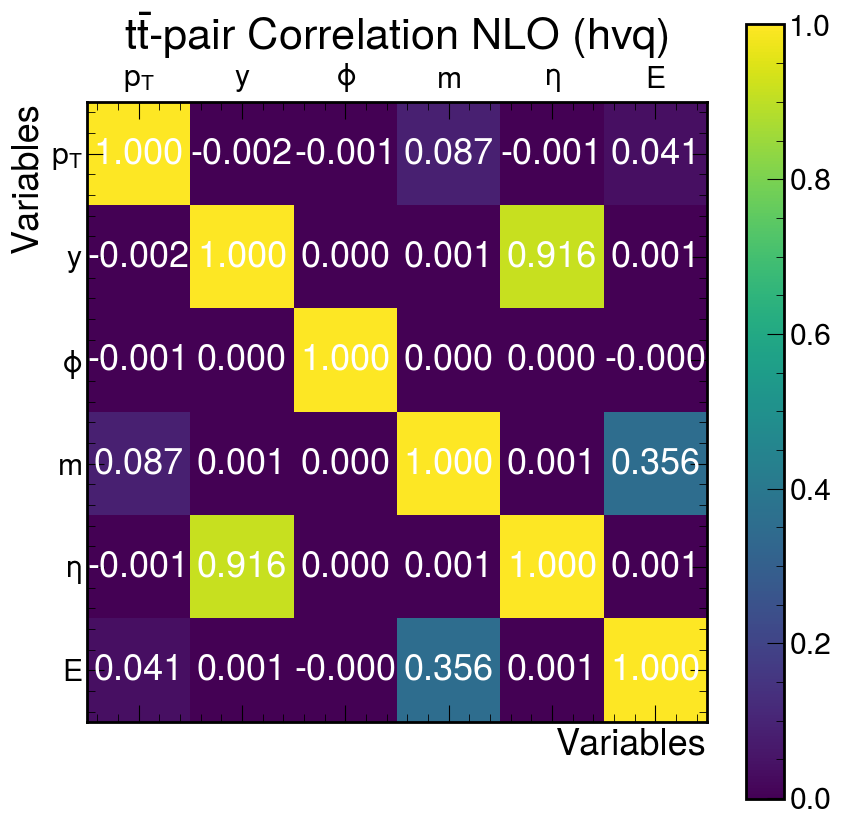

<Figure size 1246x1068 with 0 Axes>

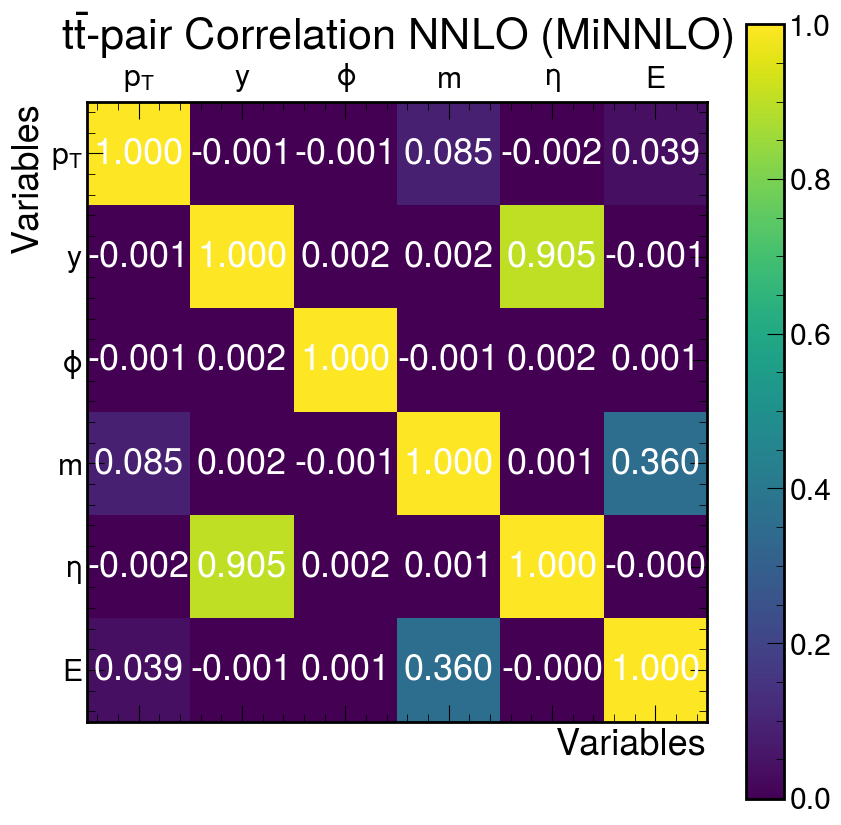

<Figure size 1246x1068 with 0 Axes>

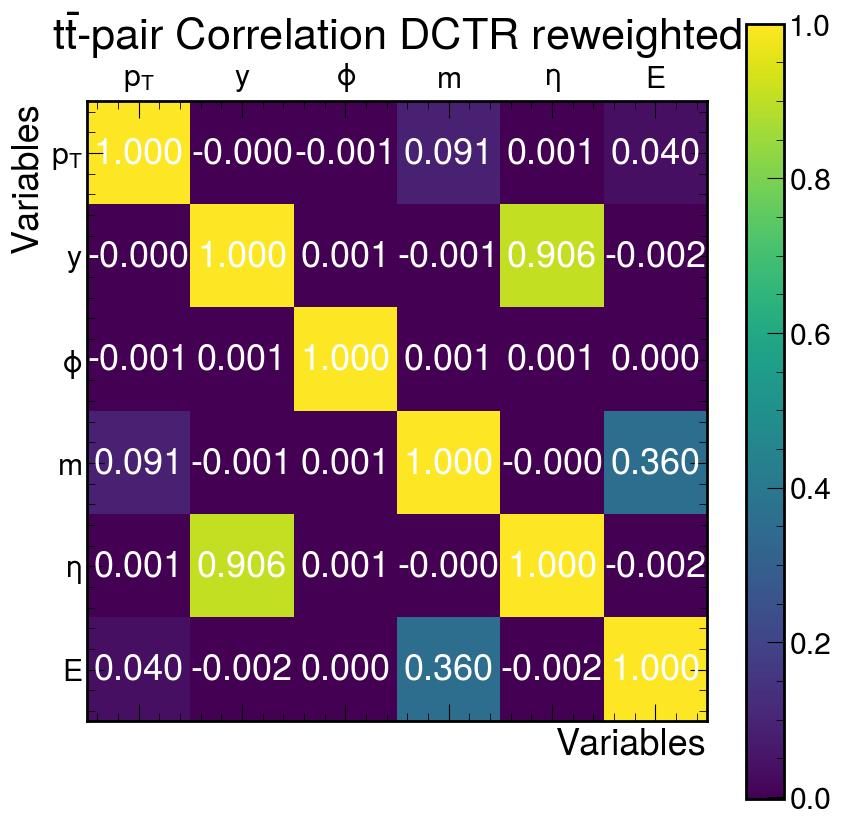

In [20]:
max_samples = int(1e6)

# correlation matrices tt-pair
# NLO hvq
corr_hvq_tt = weighted_corr(X0_plt[:int(max_samples),0,:-3], 
                            weights=X0_plt_wgt[:int(max_samples)])

plot_matrix(corr_hvq_tt, title=r'$t\bar{t}$-pair Correlation NLO (hvq)')

# NNLO MiNNLO
corr_MiNNLO_tt = weighted_corr(X1_plt[:int(max_samples),0,:-3], 
                               weights=X1_plt_wgt[:int(max_samples)])

plot_matrix(corr_MiNNLO_tt, title=r'$t\bar{t}$-pair Correlation NNLO (MiNNLO)')

# DCTR rwgt NLO -> NNLO
corr_DCTR_tt = weighted_corr(X0_plt[:int(max_samples),0,:-3], 
                            weights=rwgt[:int(max_samples)])

plot_matrix(corr_DCTR_tt, title=r'$t\bar{t}$-pair Correlation DCTR reweighted')# (NLO $\rightarrow$ NNLO)')



0.0111379634583465
0.0056995237426234885


<Figure size 1246x1068 with 0 Axes>

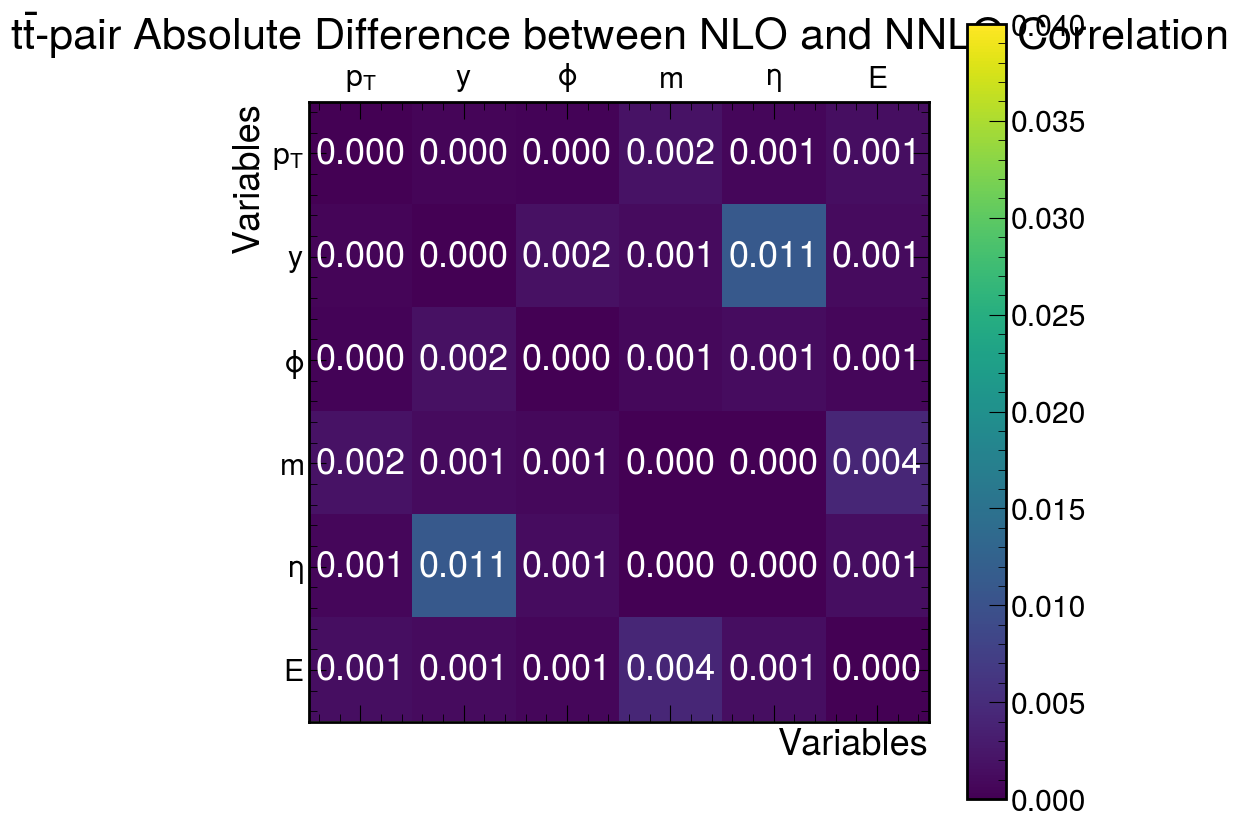

<Figure size 1246x1068 with 0 Axes>

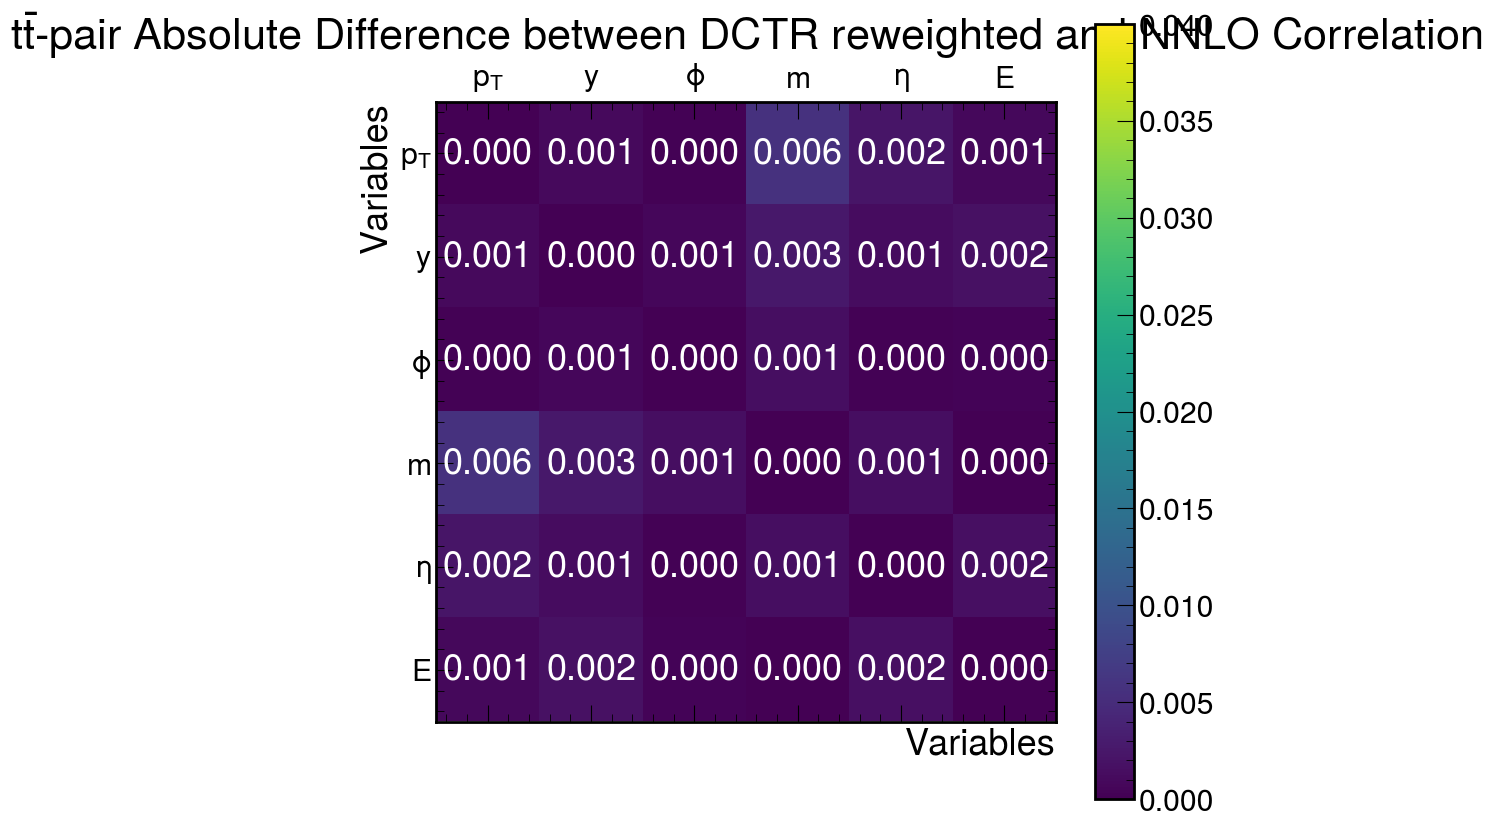

In [36]:
# difference between NNLO and NLO
# AND between NNLO and DCTR
nlo_corr_comp_tt = np.abs(corr_MiNNLO_tt - corr_hvq_tt)
DCTR_corr_comp_tt = np.abs(corr_MiNNLO_tt - corr_DCTR_tt)

print(np.max(nlo_corr_comp_tt))
print(np.max(DCTR_corr_comp_tt))

plot_matrix(nlo_corr_comp_tt, title=r'$t\bar{t}$-pair Absolute Difference between NLO and NNLO Correlation', vmin=0, vmax=0.04)
plot_matrix(DCTR_corr_comp_tt, title=r'$t\bar{t}$-pair Absolute Difference between DCTR reweighted and NNLO Correlation', vmin=0, vmax=0.04)# (NLO $\rightarrow$ NNLO)')



<Figure size 1246x1068 with 0 Axes>

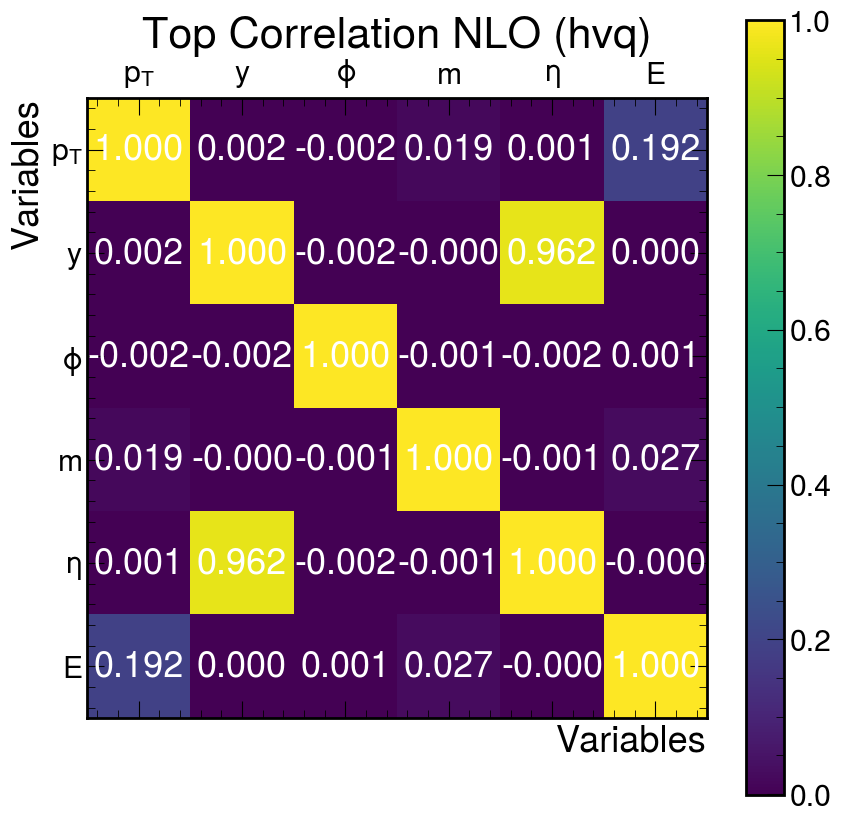

<Figure size 1246x1068 with 0 Axes>

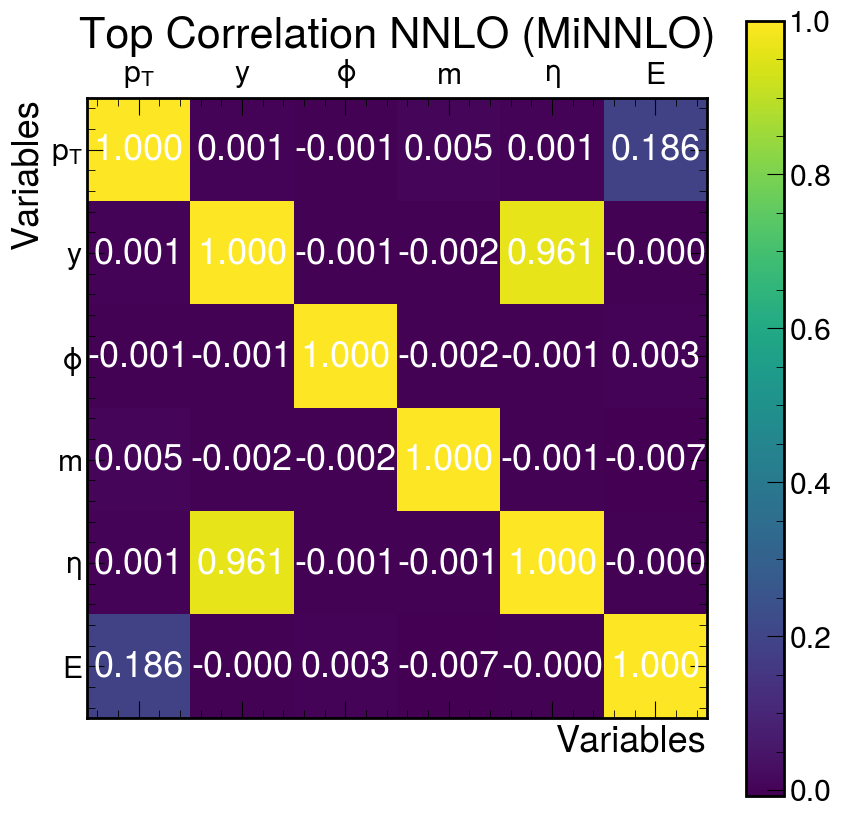

<Figure size 1246x1068 with 0 Axes>

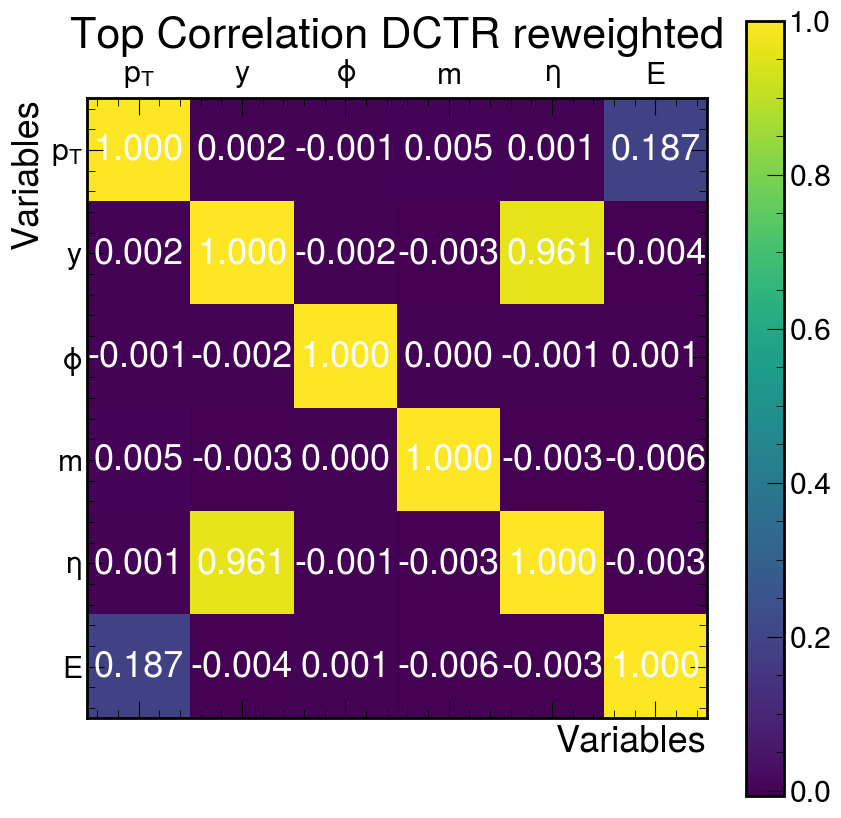

In [29]:
max_samples = int(1e6)

# correlation matrices top
# NLO hvq
corr_hvq_top = weighted_corr(X0_plt[:int(max_samples),1,:-3], 
                            weights=X0_plt_wgt[:int(max_samples)])

plot_matrix(corr_hvq_top, title=r'Top Correlation NLO (hvq)')

# NNLO MiNNLO
corr_MiNNLO_top = weighted_corr(X1_plt[:int(max_samples),1,:-3], 
                               weights=X1_plt_wgt[:int(max_samples)])

plot_matrix(corr_MiNNLO_top, title=r'Top Correlation NNLO (MiNNLO)')

# DCTR rwgt NLO -> NNLO
corr_DCTR_top = weighted_corr(X0_plt[:int(max_samples),1,:-3], 
                            weights=rwgt[:int(max_samples)])

plot_matrix(corr_DCTR_top, title=r'Top Correlation DCTR reweighted')# (NLO $\rightarrow$ NNLO)')



0.034349739600718535
0.0037129711738579365


<Figure size 1246x1068 with 0 Axes>

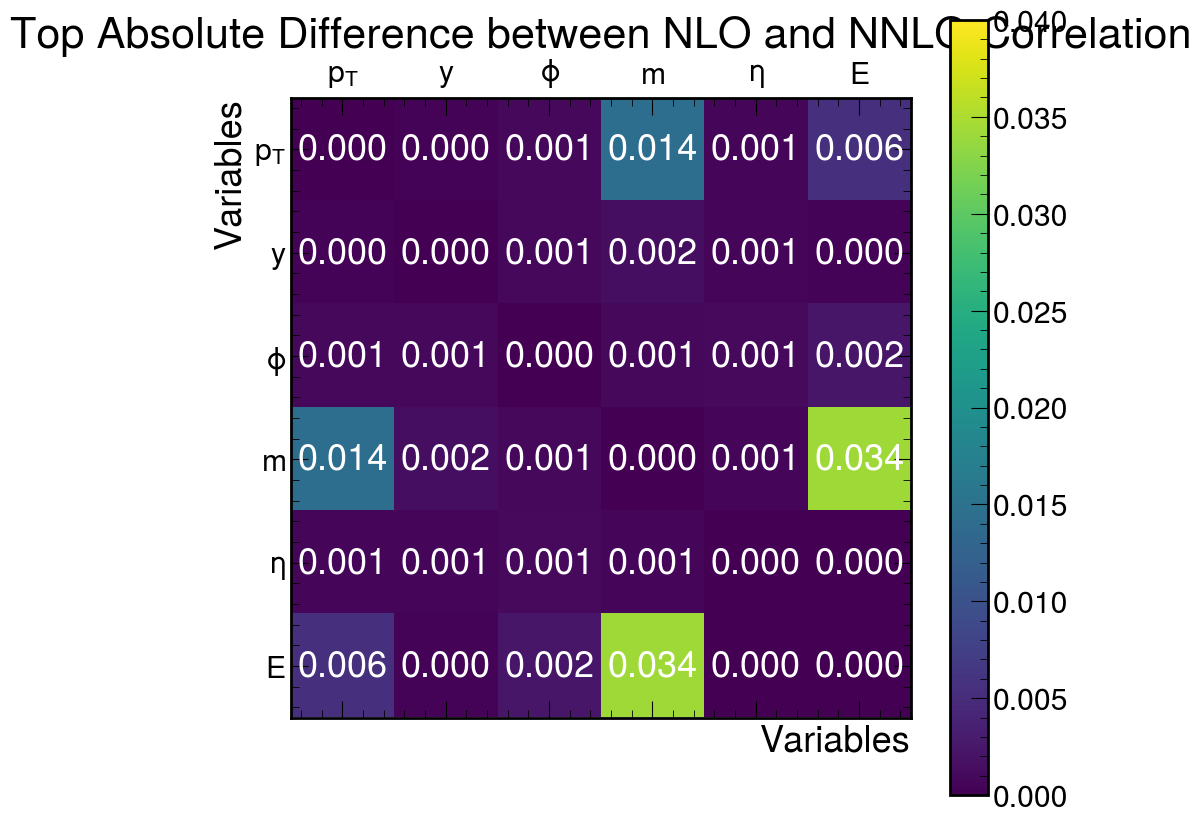

<Figure size 1246x1068 with 0 Axes>

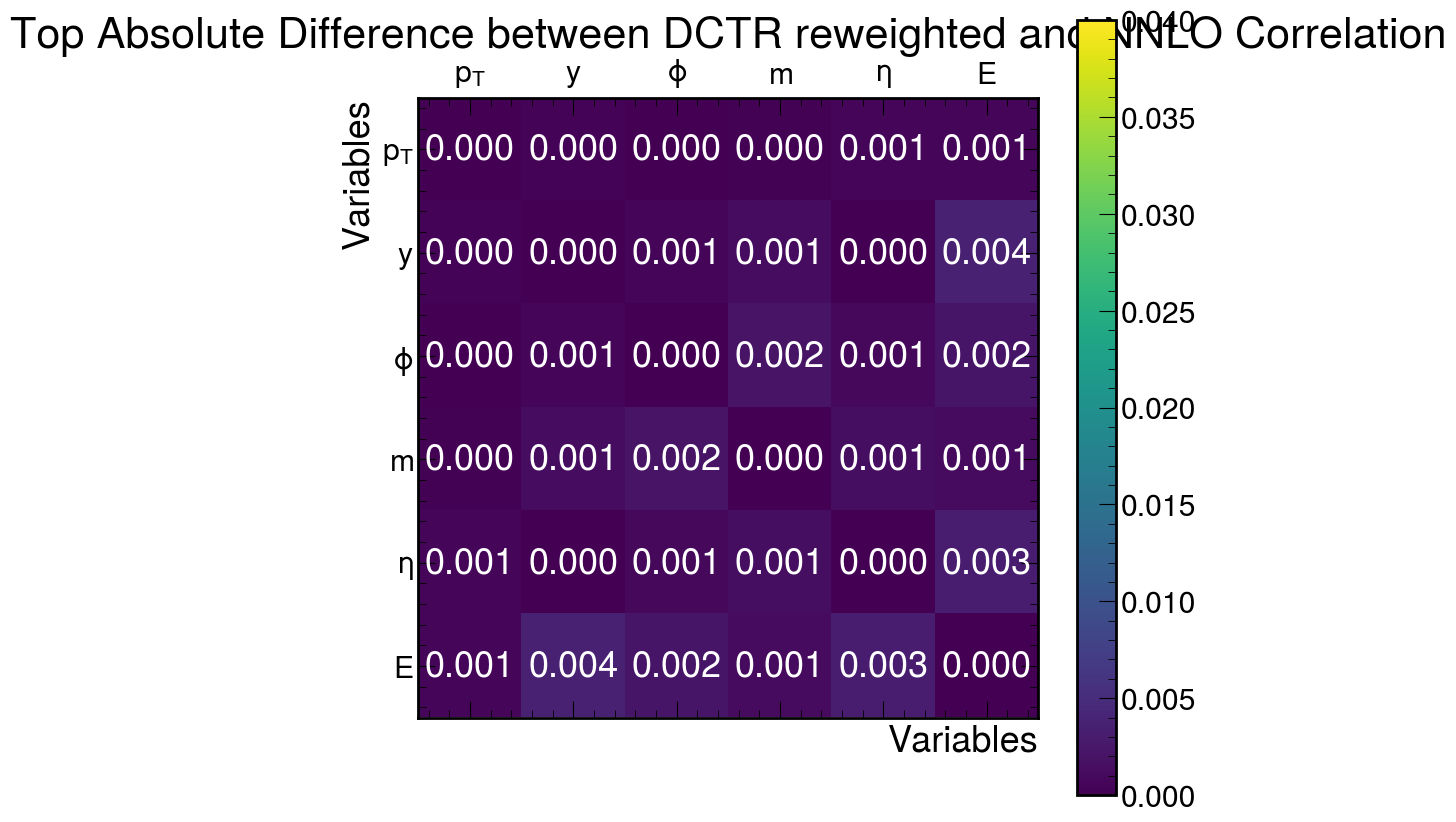

In [35]:
# difference between NNLO and NLO
# AND between NNLO and DCTR

nlo_corr_comp_top = np.abs(corr_MiNNLO_top - corr_hvq_top)
DCTR_corr_comp_top = np.abs(corr_MiNNLO_top - corr_DCTR_top)

print(np.max(nlo_corr_comp_top))
print(np.max(DCTR_corr_comp_top))

plot_matrix(nlo_corr_comp_top, title=r'Top Absolute Difference between NLO and NNLO Correlation', vmin=0, vmax=0.04)
plot_matrix(DCTR_corr_comp_top, title=r'Top Absolute Difference between DCTR reweighted and NNLO Correlation', vmin=0, vmax=0.04)


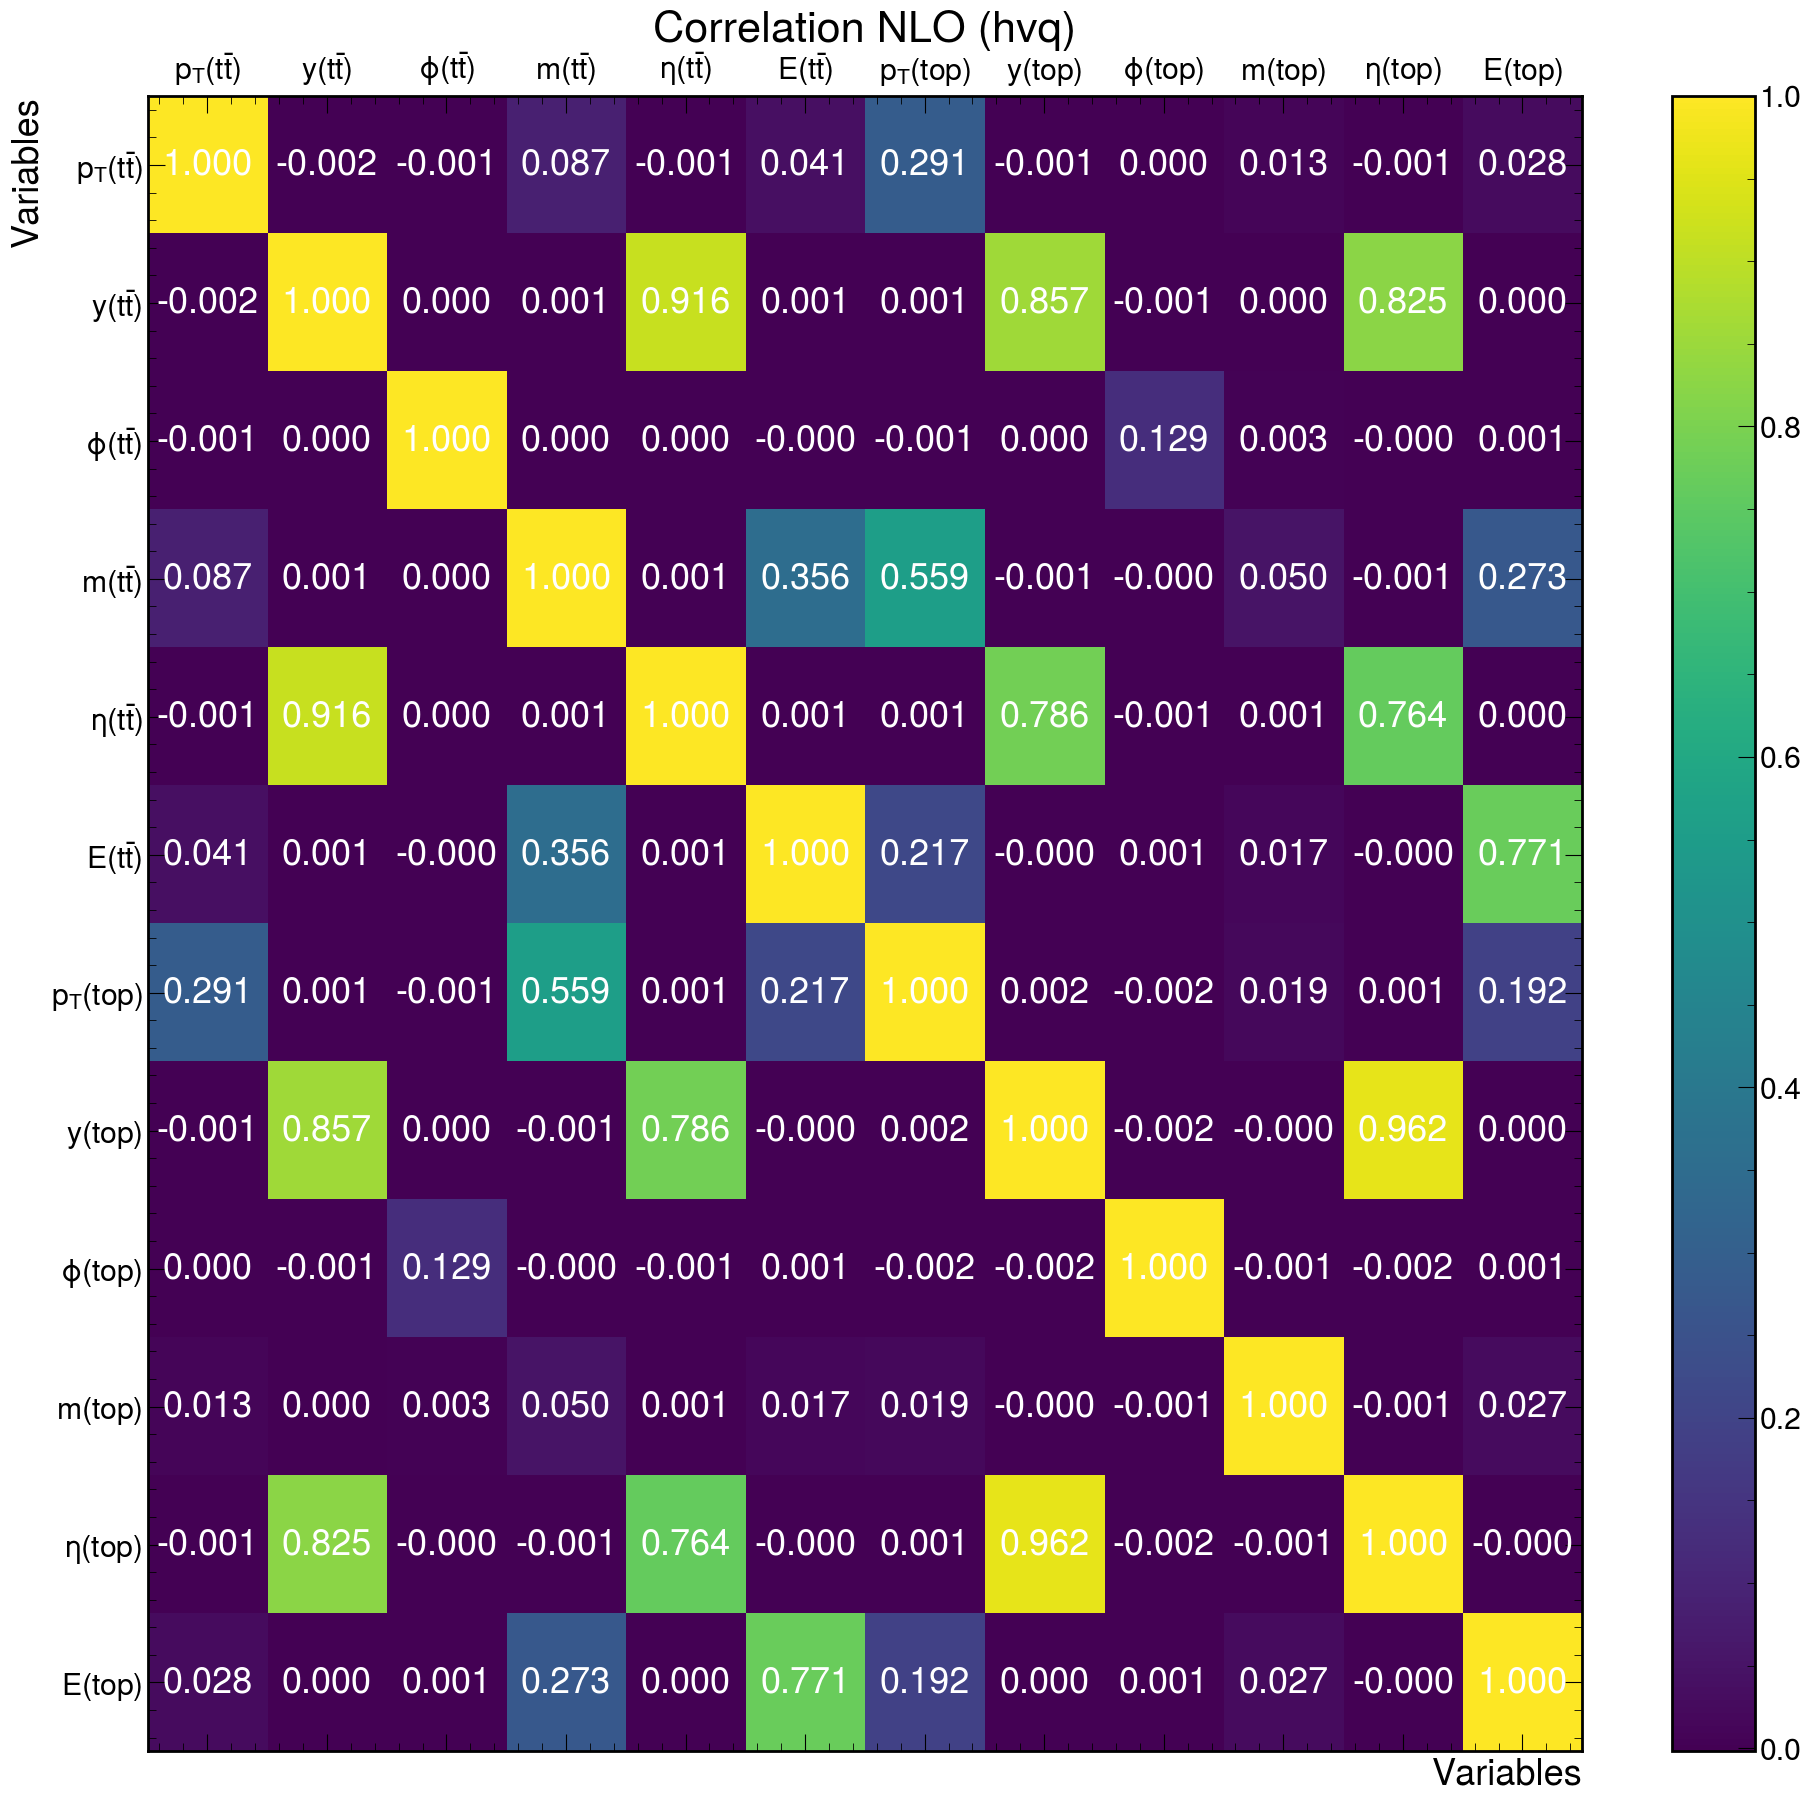

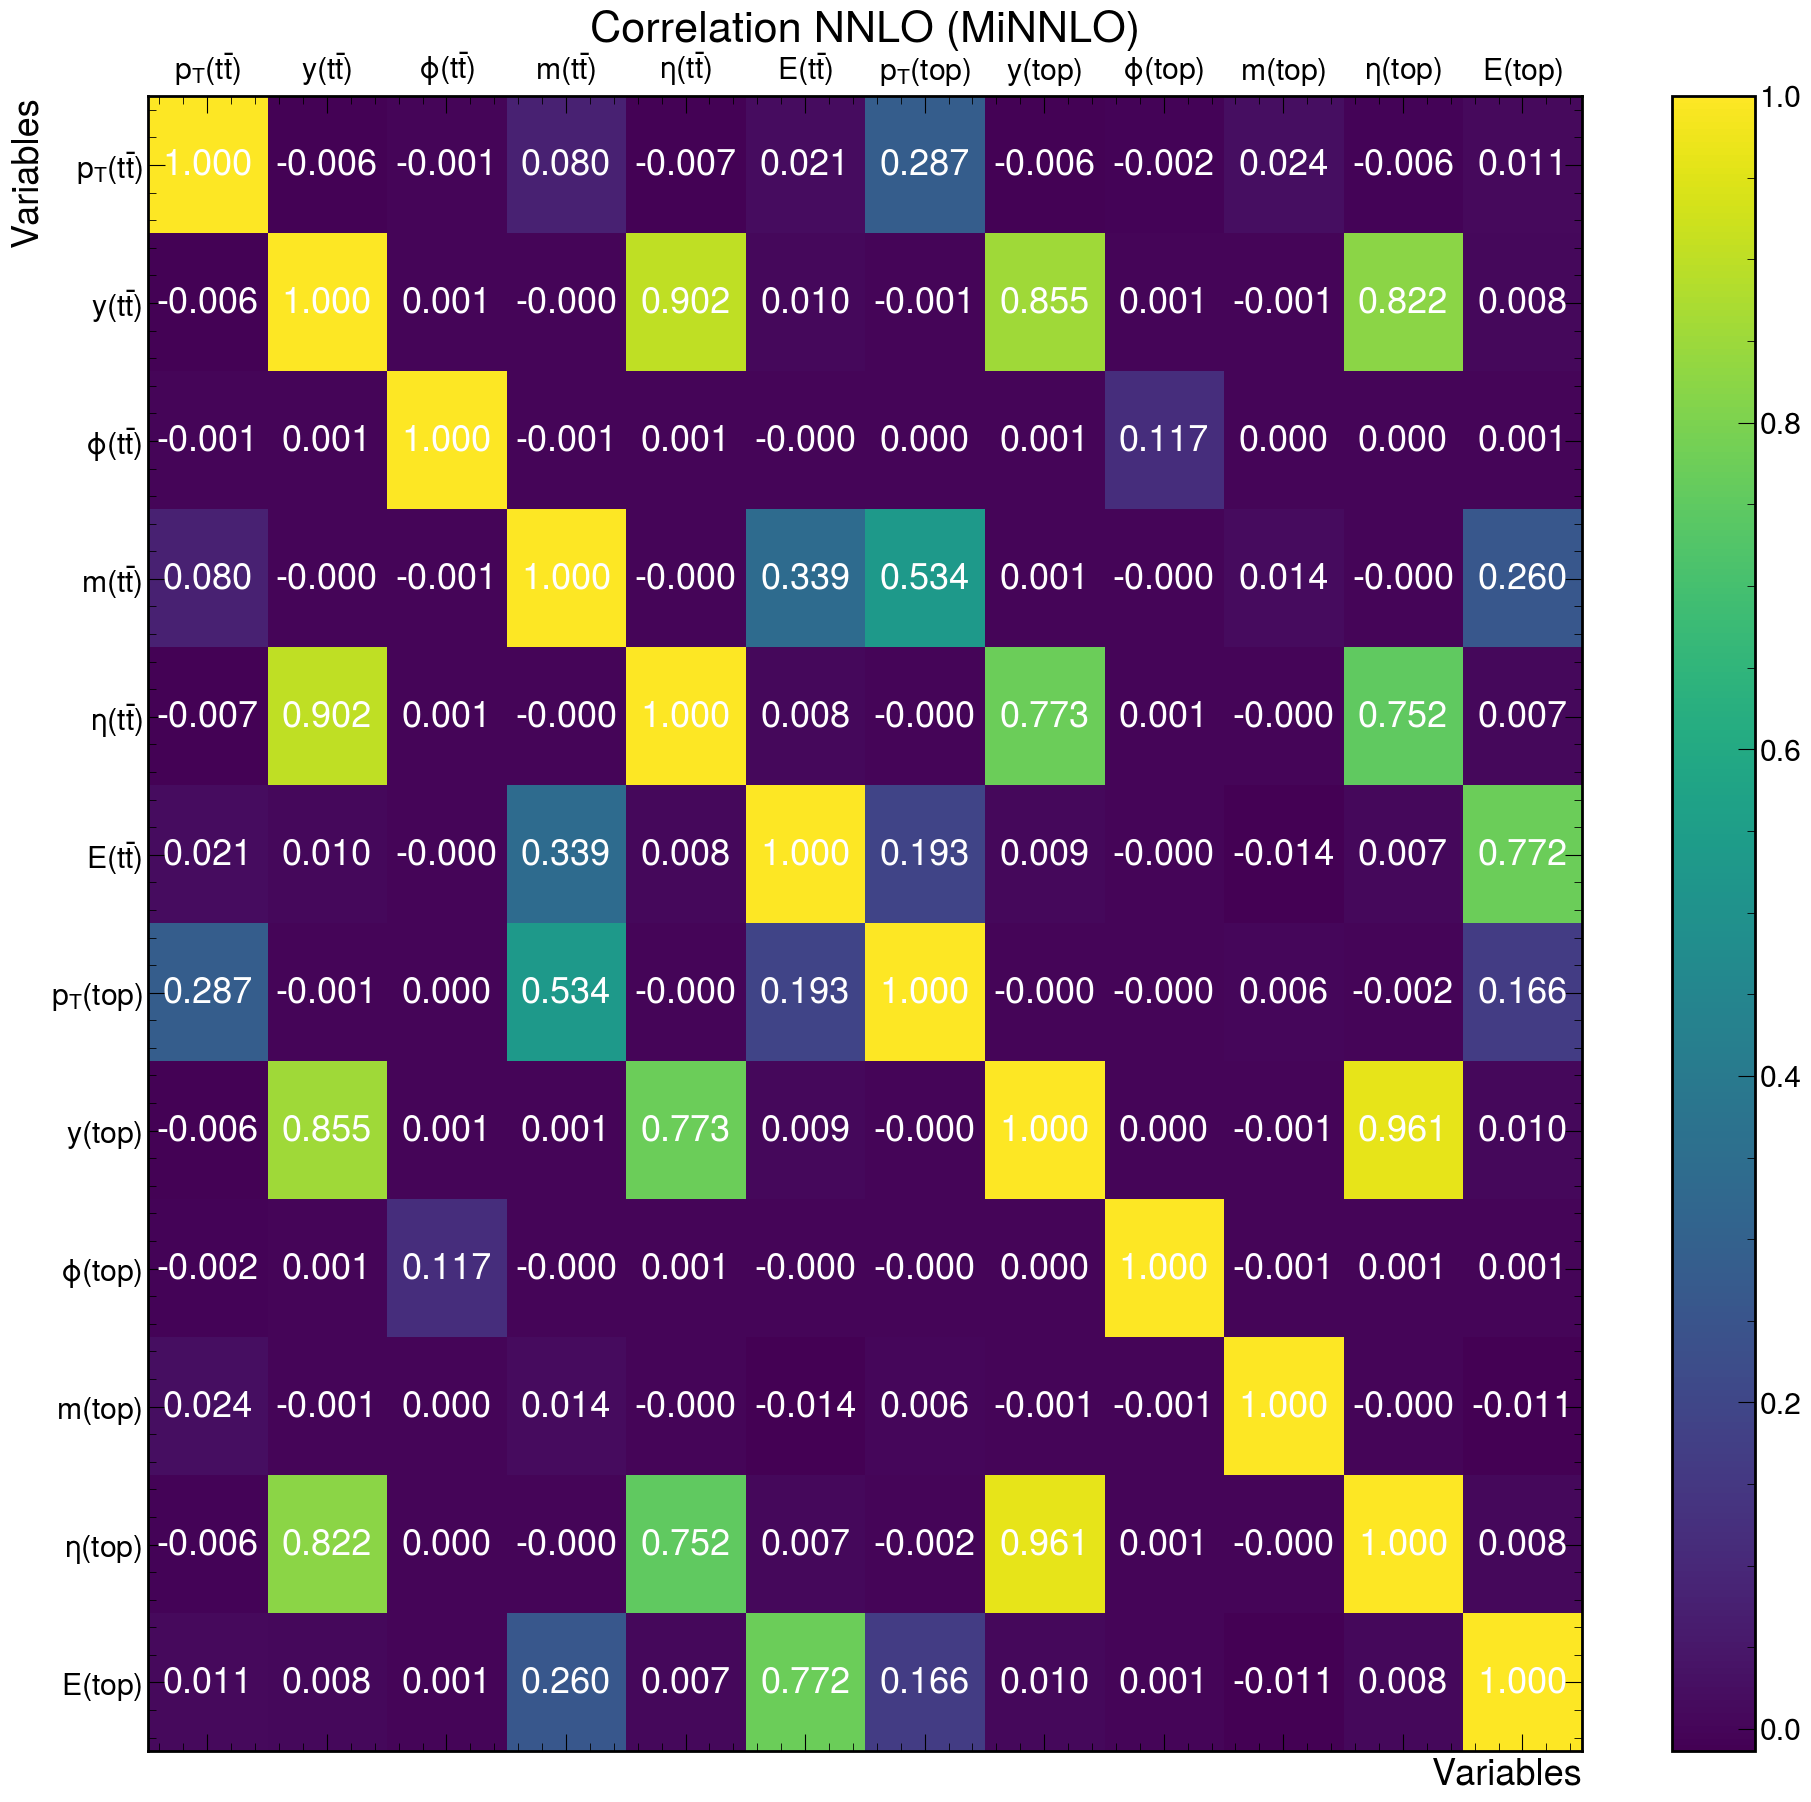

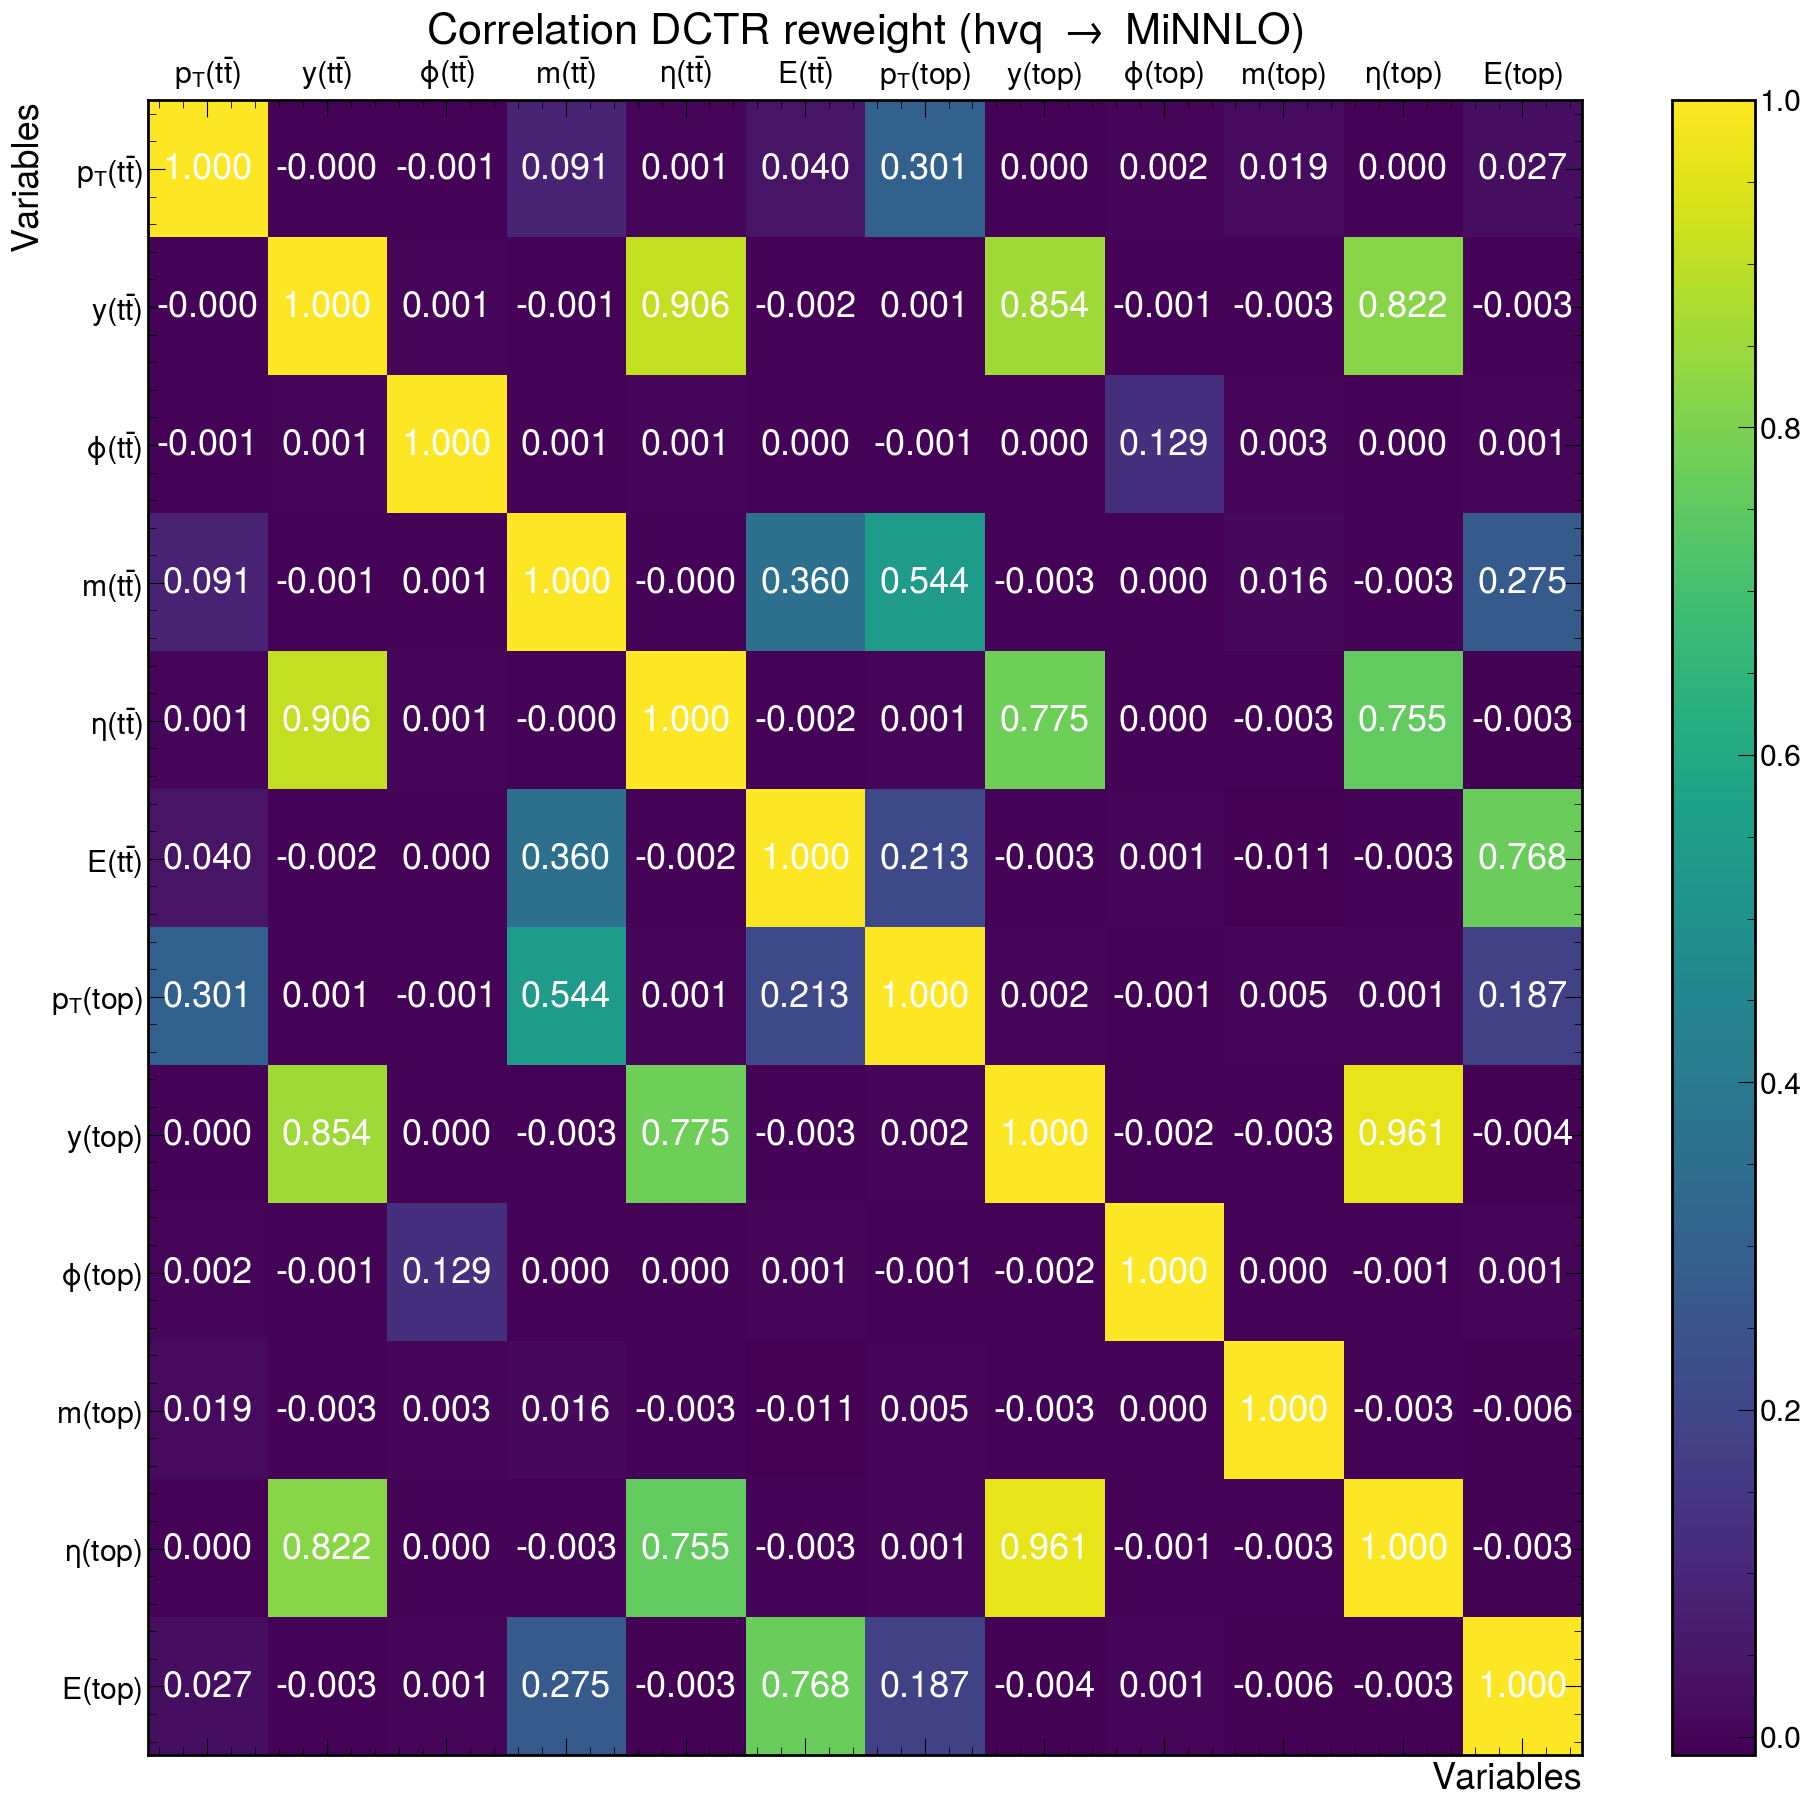

In [31]:
# correlation matrices between tt ant top

max_samples = int(1e6)

# create full array. Concat transposed to add as extra attribute, not extra events
# transpose output to have (n_samples, n_attributes) again
X0_full = np.concatenate((X0_plt[:int(max_samples),0,:-3].T,    # tt-pair
                          X0_plt[:int(max_samples),1,:-3].T)).T # top

X1_full = np.concatenate((X1_plt[:int(max_samples),0,:-3].T,    # tt-pair
                          X1_plt[:int(max_samples),1,:-3].T)).T # top

# correlation matrices tt-pair
# NLO hvq
corr_hvq_full = weighted_corr(X0_full, weights=X0_plt_wgt[:int(max_samples)])

plot_matrix_full(corr_hvq_full, title=r'Correlation NLO (hvq)')

# NNLO MiNNLO
corr_MiNNLO_full = weighted_corr(X1_full, weights=X0_plt_wgt[:int(max_samples)])

plot_matrix_full(corr_MiNNLO_full, title=r'Correlation NNLO (MiNNLO)')

# DCTR rwgt NLO -> NNLO
corr_DCTR_full = weighted_corr(X0_full, weights=rwgt[:int(max_samples)])

plot_matrix_full(corr_DCTR_full, title=r'Correlation DCTR reweight (hvq $\rightarrow$ MiNNLO)')



0.03807738614828424
0.021368012091202704


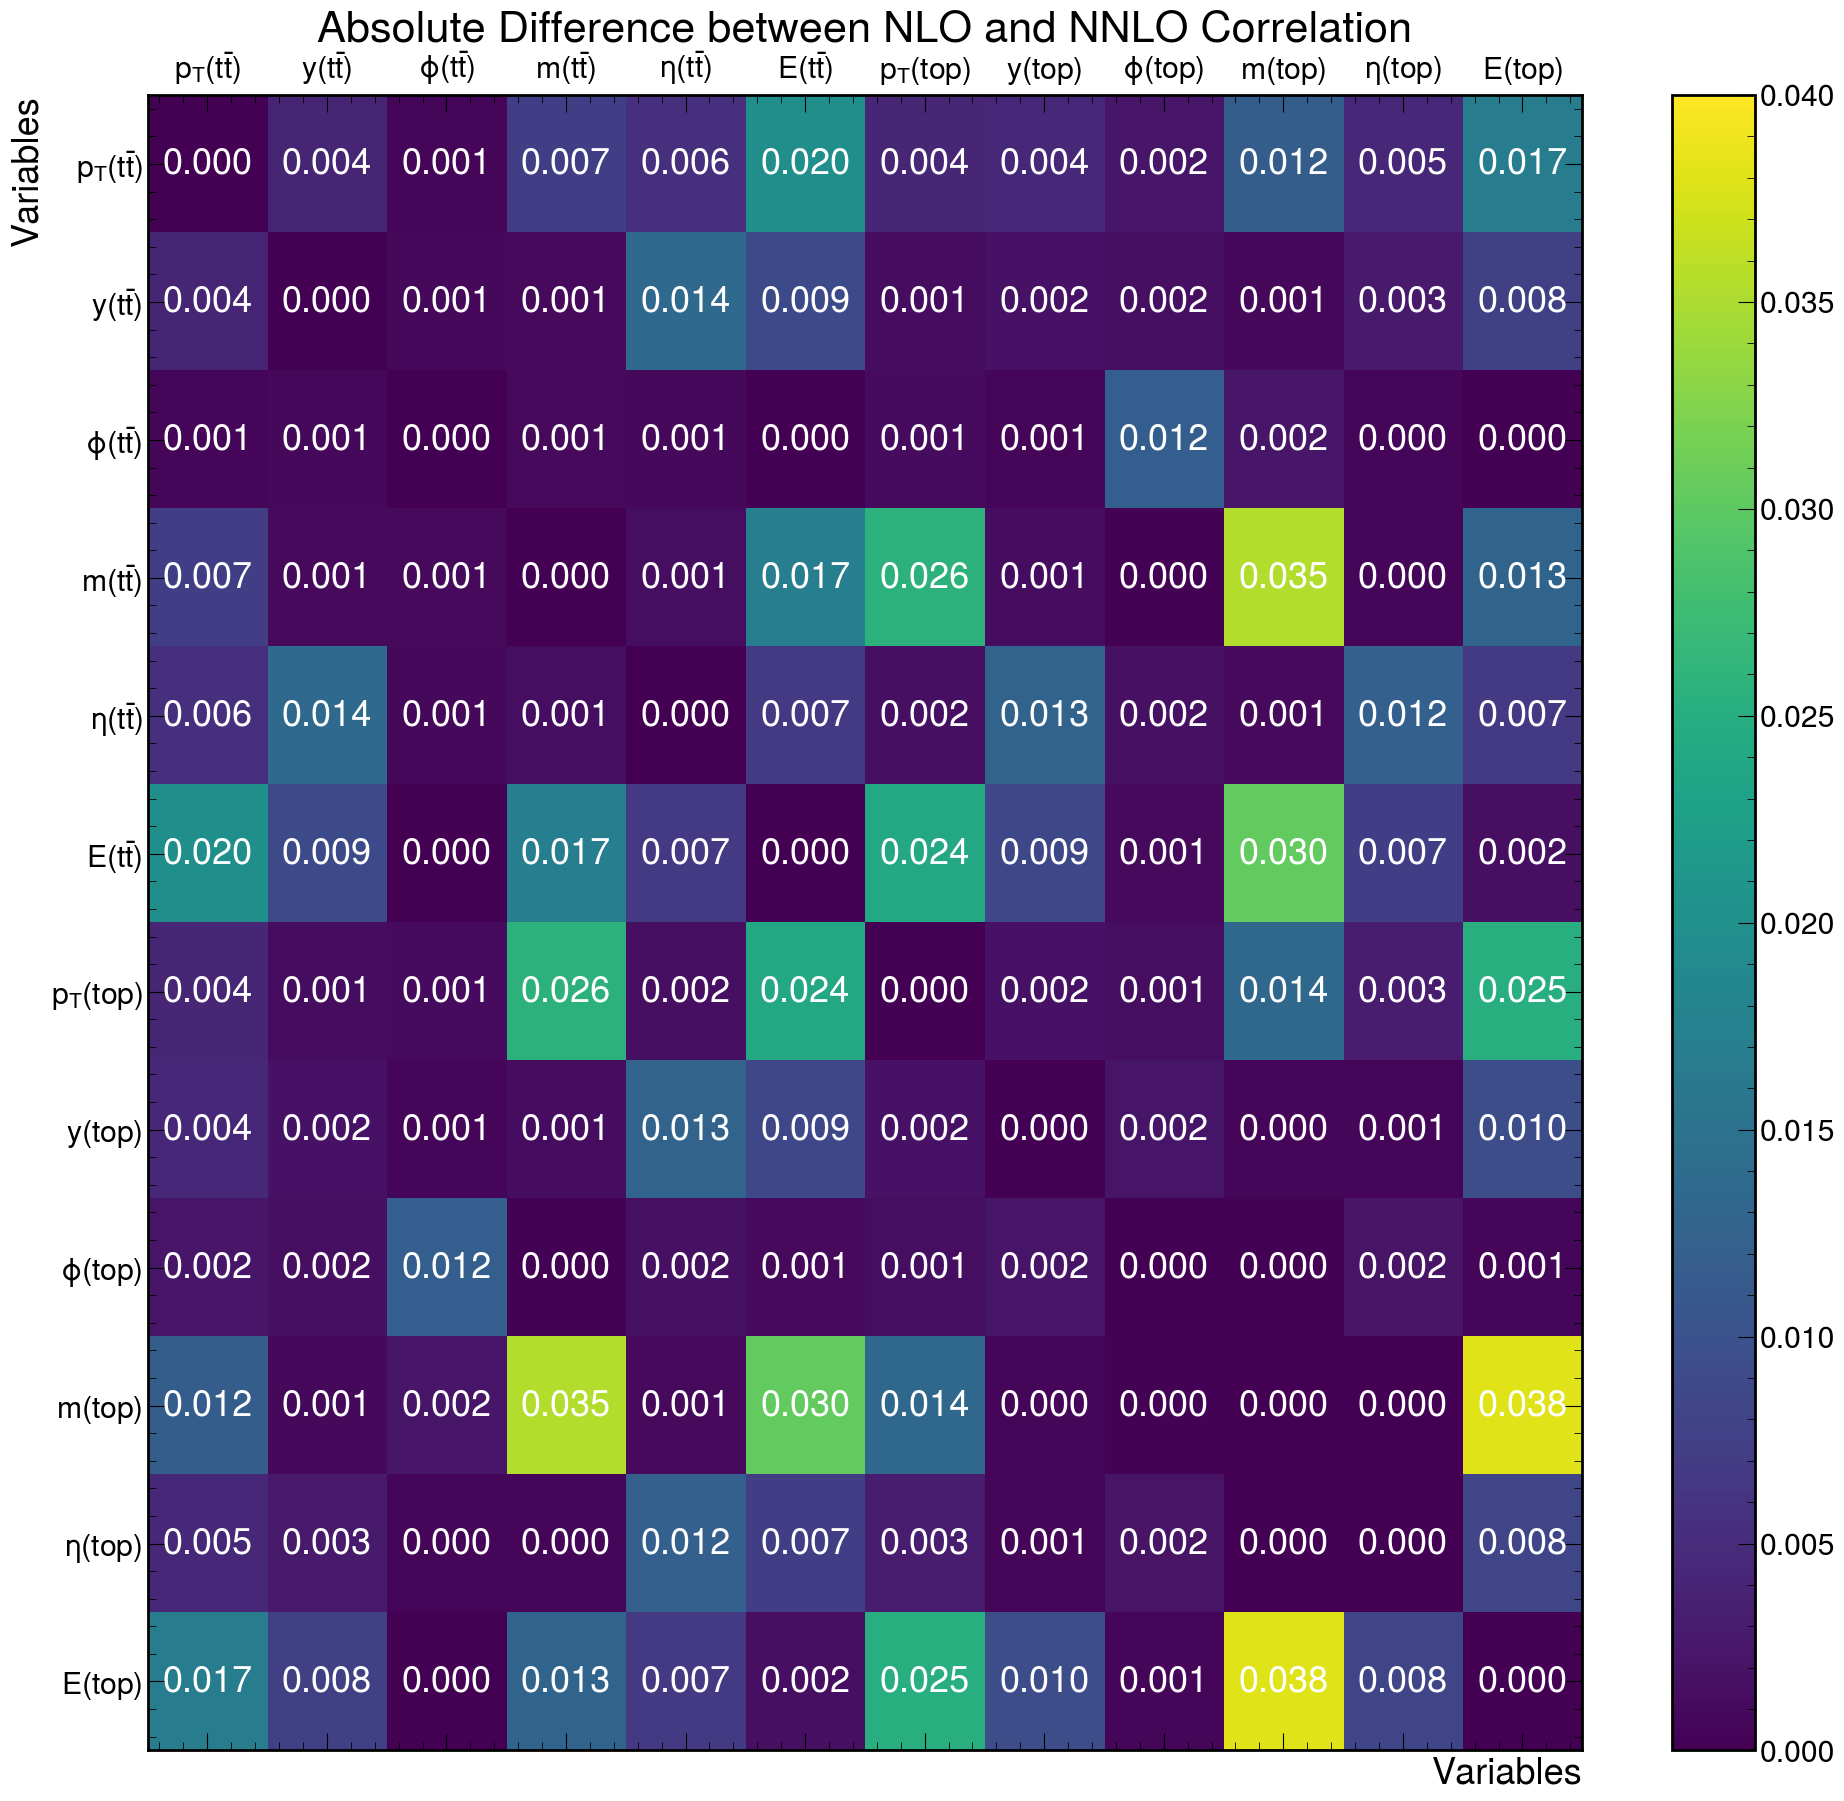

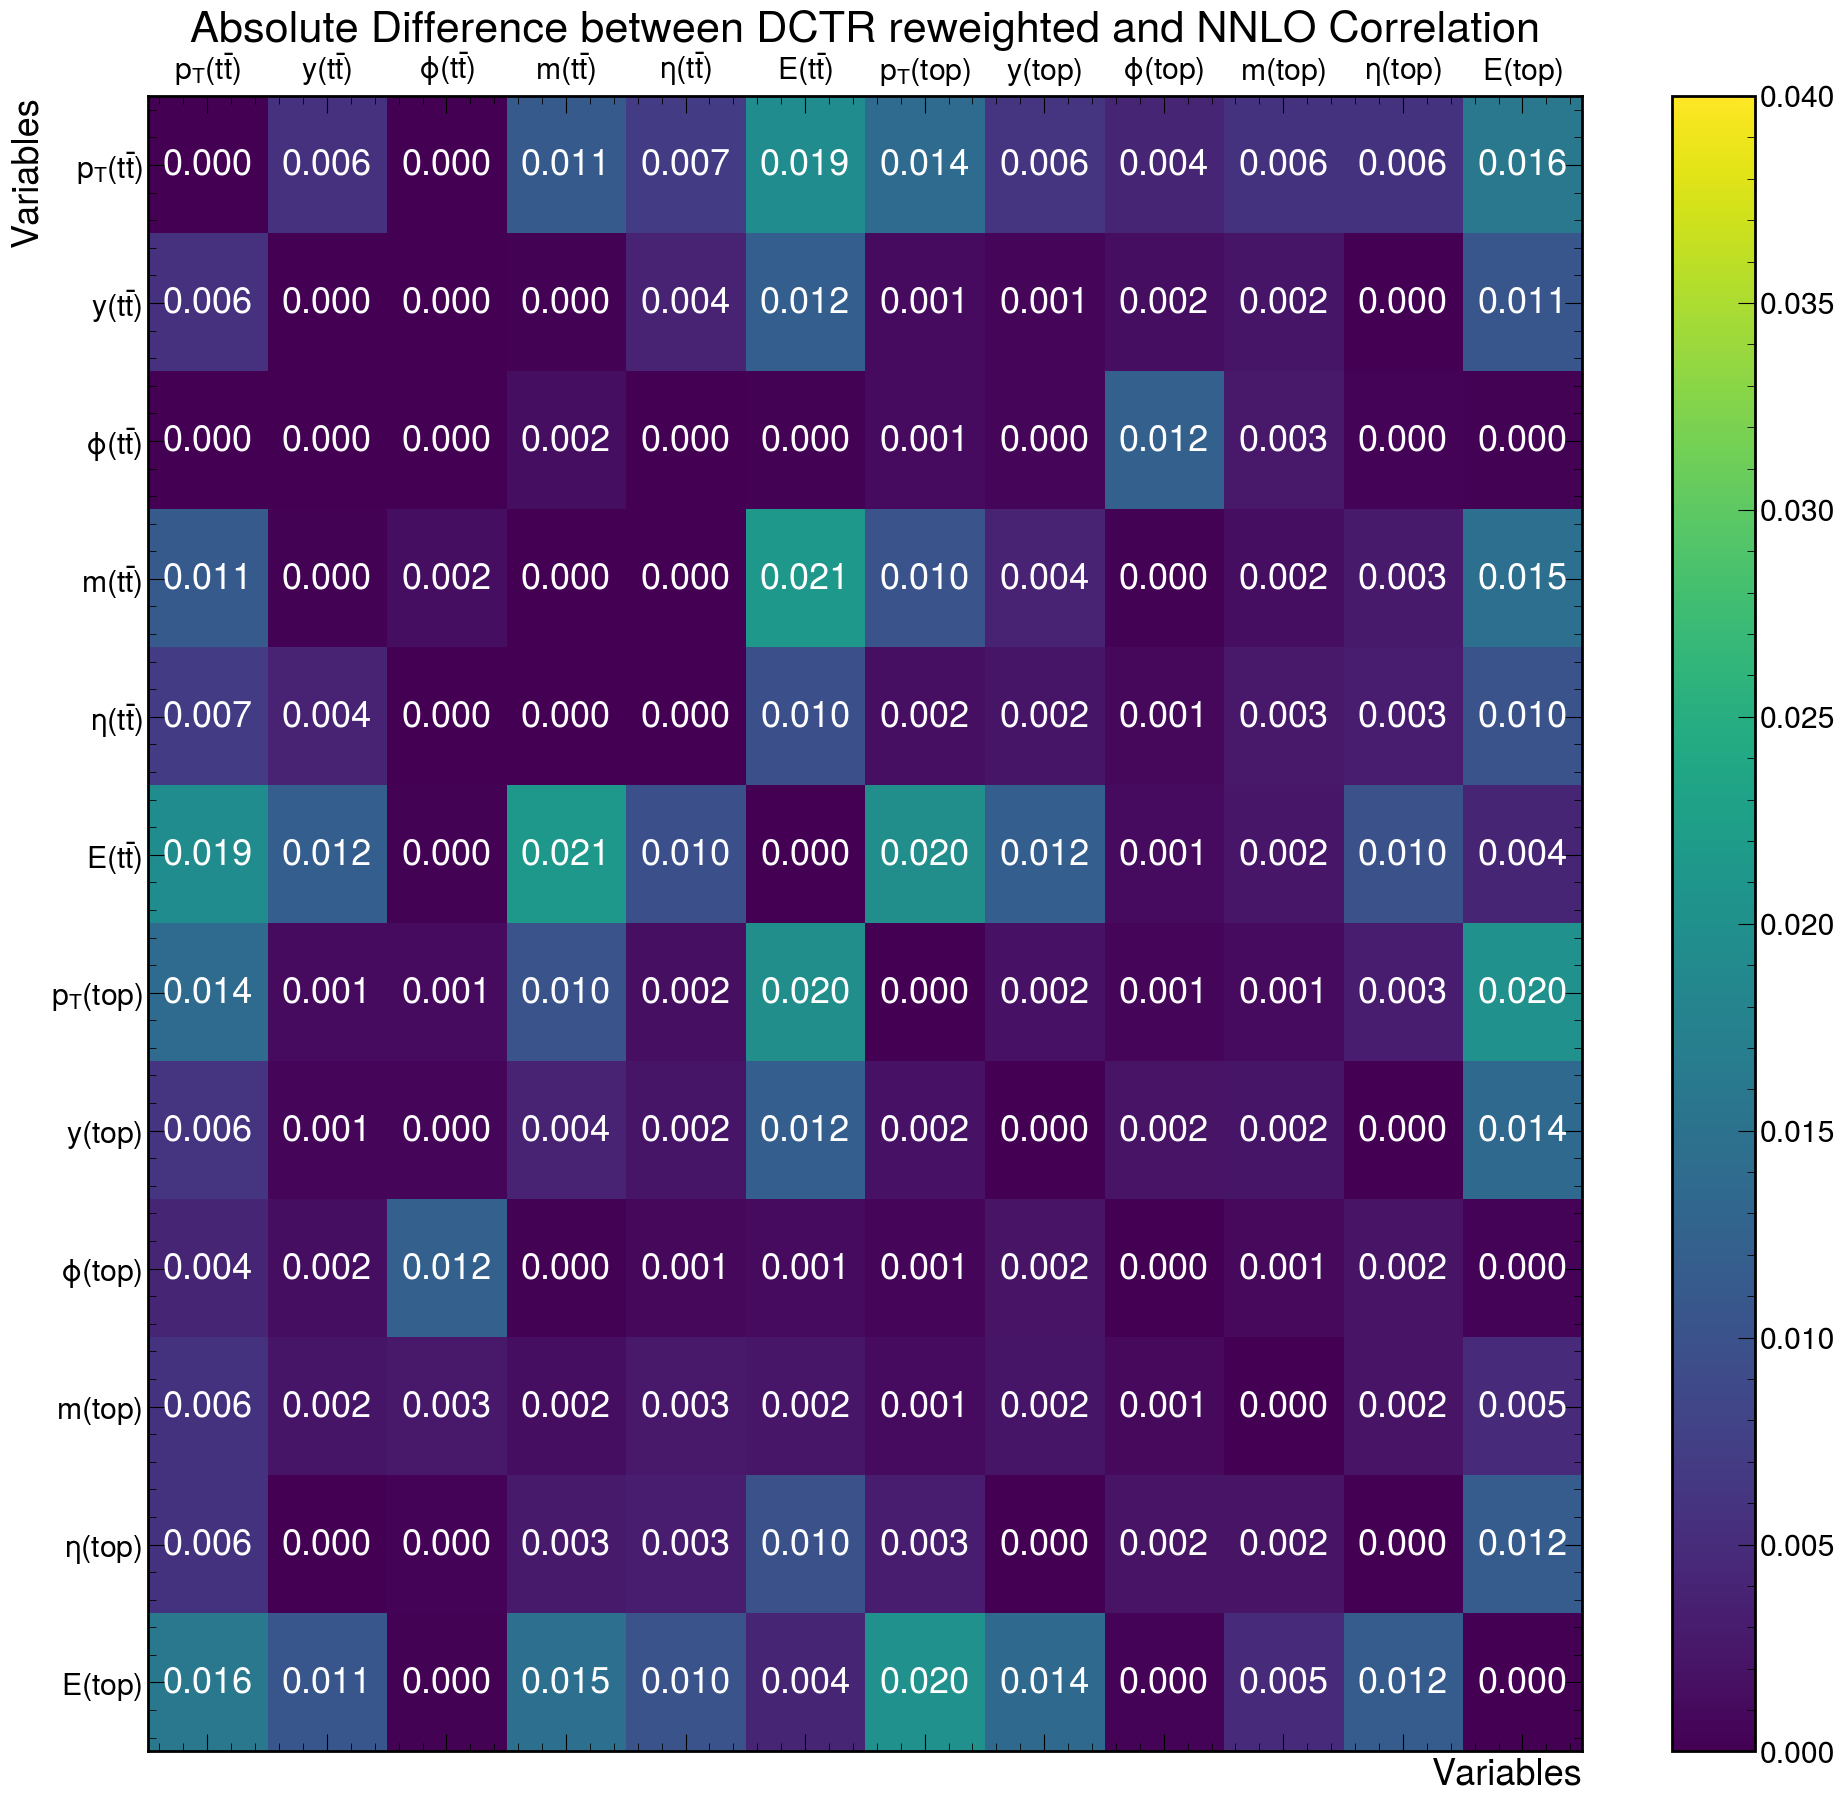

In [34]:
# difference between NNLO and NLO
# AND between NNLO and DCTR

nlo_corr_comp_full = np.abs(corr_MiNNLO_full - corr_hvq_full)
DCTR_corr_comp_full = np.abs(corr_MiNNLO_full - corr_DCTR_full)

# to set proper vmin and vmax in matrix plotting function
print(np.max(nlo_corr_comp_full))
print(np.max(DCTR_corr_comp_full))

plot_matrix_full(nlo_corr_comp_full, title=r'Absolute Difference between NLO and NNLO Correlation', vmin=0, vmax=0.04)
plot_matrix_full(DCTR_corr_comp_full, title=r'Absolute Difference between DCTR reweighted and NNLO Correlation', vmin=0, vmax=0.04)
